In [31]:
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import keras
import cv2
import random

from tensorflow.keras.applications import ResNet152
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from common import load_image_labels, load_predict_image_names, load_single_image, save_model, load_model
from common import load_image_labels, load_predict_image_names, load_single_image, save_model, load_model

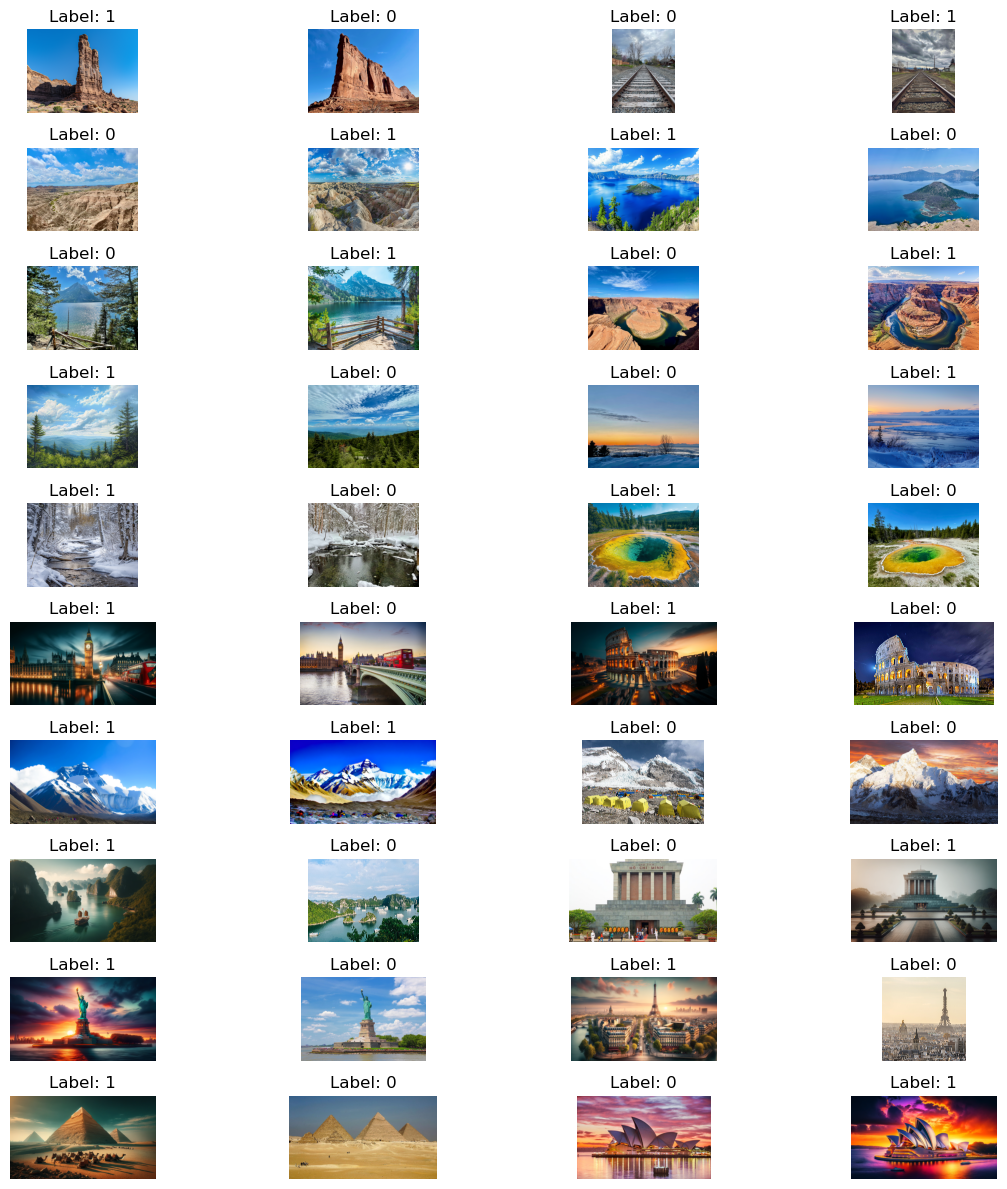

In [32]:
# get label of data
labels_file_path = "./data/Data - Is GenAI - 2024-03-25/Labels-IsGenAi-2024-03-25.csv"
df_data = load_image_labels(labels_file_path)
labels = df_data['Is GenAI'].tolist()
labels = [1 if label == 'Yes' else 0 for label in labels]

# get all images
data_path = "./data/Data - Is GenAI - 2024-03-25/"
images_name = df_data['Filename'].tolist()
image_paths = []
# load all the image path that ends with .png into the images_paths list
for filename in images_name:
    image_path = os.path.join(data_path, filename)
    image_paths.append(image_path)

# Load all PNG images in the image_path list and its label
images = [Image.open(image_path) for image_path in image_paths]
num_rows = 10
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for image, label, ax in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    ax.set_title("Label: " + str(label))
    ax.axis('off')
    
plt.tight_layout()
plt.show()

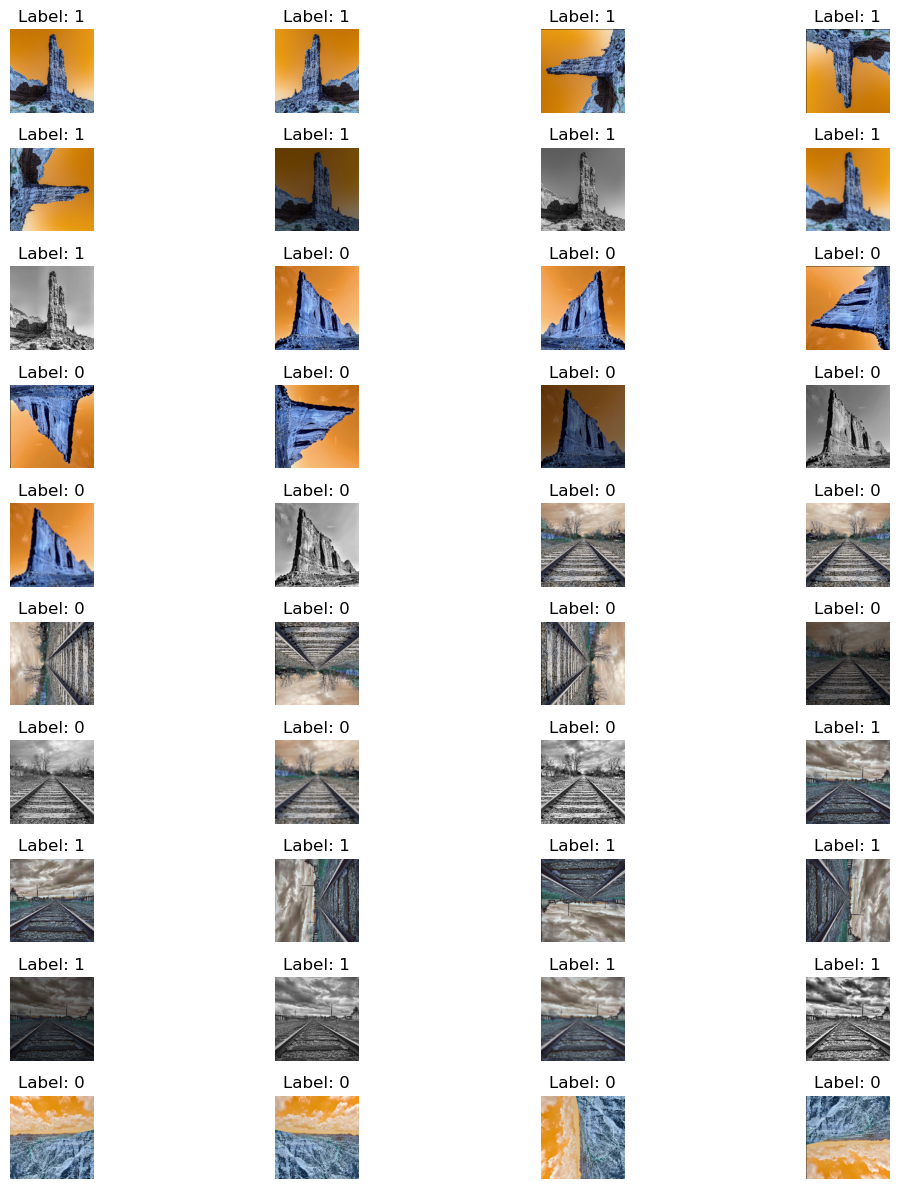

In [33]:
# preprocessed_images = [preprocess_image(image) for image in images]
def preprocess_image_function(image):
    preprocess_image = np.array(image)
    preprocess_image = cv2.resize(preprocess_image, (224, 224))
    preprocess_image = cv2.cvtColor(preprocess_image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    
    return preprocess_image

def flip_images(image):
    preprocess_image = preprocess_image_function(image)
    
    flipped_image = cv2.flip(preprocess_image, 1)
    return flipped_image

def rotate_90(image):
    preprocess_image = preprocess_image_function(image)
        
    rows, cols, _ = preprocess_image.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), 90, 1)
    rotated_image = cv2.warpAffine(preprocess_image, rotation_matrix, (cols, rows))
    
    return rotated_image

def rotate_180(image):
    preprocess_image = preprocess_image_function(image)
        
    rows, cols, _ = preprocess_image.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), 180, 1)
    rotated_image = cv2.warpAffine(preprocess_image, rotation_matrix, (cols, rows))
    
    return rotated_image

def rotate_270(image):
    preprocess_image = preprocess_image_function(image)
        
    rows, cols, _ = preprocess_image.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), 270, 1)
    rotated_image = cv2.warpAffine(preprocess_image, rotation_matrix, (cols, rows))
    
    return rotated_image

def adjust_brightness(image):
    preprocess_image = preprocess_image_function(image)
    
    hsv_image = cv2.cvtColor(preprocess_image, cv2.COLOR_BGR2HSV)
    brightness_factor = 0.5  # Specify brightness factor
    hsv_image[:, :, 2] = np.clip(hsv_image[:, :, 2] * brightness_factor, 0, 255)
    brightened_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
    
    return brightened_image

def gray_scale(image):
    preprocess_image = preprocess_image_function(image)
    
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(preprocess_image, cv2.COLOR_BGR2GRAY)
    # Convert grayscale image to 3-channel format
    gray_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)
    
    return gray_image

def apply_gaussian_blur(image):
    preprocess_image = preprocess_image_function(image)
    blurred_image = cv2.GaussianBlur(preprocess_image, (5, 5), 0)
    return blurred_image

def enhance_contrast(image):
    preprocess_image = preprocess_image_function(image)  
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(preprocess_image, cv2.COLOR_RGB2GRAY)
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(gray_image)
    # Convert back to 3-channel format
    enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2RGB)
    return enhanced_image

# Apply the preprocess_image function to the image array
preprocessed_images = []
for image in images:
    preprocessed_images.append(preprocess_image_function(image))
    preprocessed_images.append(flip_images(image))
    preprocessed_images.append(rotate_90(image))
    preprocessed_images.append(rotate_180(image))
    preprocessed_images.append(rotate_270(image))
    preprocessed_images.append(adjust_brightness(image))
    preprocessed_images.append(gray_scale(image))
    preprocessed_images.append(apply_gaussian_blur(image))
    preprocessed_images.append(enhance_contrast(image))

# get label of data
labels_file_path = "./data/Data - Is GenAI - 2024-03-25/Labels-IsGenAi-2024-03-25.csv"
df_data = load_image_labels(labels_file_path)
labels = df_data['Is GenAI'].tolist()
labels = [1 if label == 'Yes' else 0 for label in labels]
# Fix label to be correct with the augment
labels = [label for label in labels for _ in range(9)]

num_rows = 10
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for image, label, ax in zip(preprocessed_images, labels, axes.flatten()):
    ax.imshow(image)
    ax.set_title("Label: " + str(label))
    ax.axis('off')
    
plt.tight_layout()
plt.show()

In [34]:
# Split the data into train and test sets (80% train, 20% validation)
train_images, val_images, train_labels, val_labels = train_test_split(preprocessed_images, labels, test_size=0.2, random_state=42)

# Convert lists of images to NumPy arrays
train_images = np.array(train_images)
val_images = np.array(val_images)

# Convert lists of labels to NumPy arrays
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

Epoch 1/20
47/47 [==============================] - 17s 230ms/step - loss: 1.0594 - accuracy: 0.7053 - val_loss: 0.3309 - val_accuracy: 0.8618
Epoch 2/20
47/47 [==============================] - 8s 176ms/step - loss: 0.1297 - accuracy: 0.9654 - val_loss: 0.1754 - val_accuracy: 0.9241
Epoch 3/20
47/47 [==============================] - 8s 177ms/step - loss: 0.0270 - accuracy: 0.9993 - val_loss: 0.1561 - val_accuracy: 0.9404
Epoch 4/20
47/47 [==============================] - 8s 177ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.1596 - val_accuracy: 0.9539
Epoch 5/20
47/47 [==============================] - 8s 178ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.1504 - val_accuracy: 0.9404
Epoch 6/20
47/47 [==============================] - 8s 178ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.1496 - val_accuracy: 0.9458
Epoch 7/20
47/47 [==============================] - 8s 179ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1568 - val_accuracy: 0.9431
Epoch

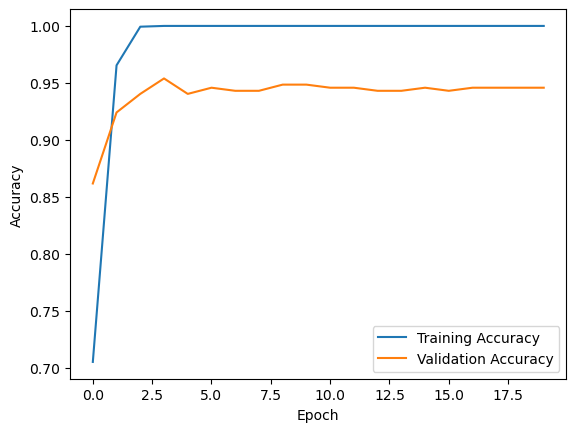

In [35]:
# Load pre-trained VGG19 model
resnet_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers
for layer in resnet_model.layers:
    layer.trainable = False

# Add classification head
model = Sequential([
    resnet_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=20, batch_size=32, verbose=1)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [36]:
# Save the model weight
model.save_weights("ai_human_classify_model_weights_resnet152.h5")

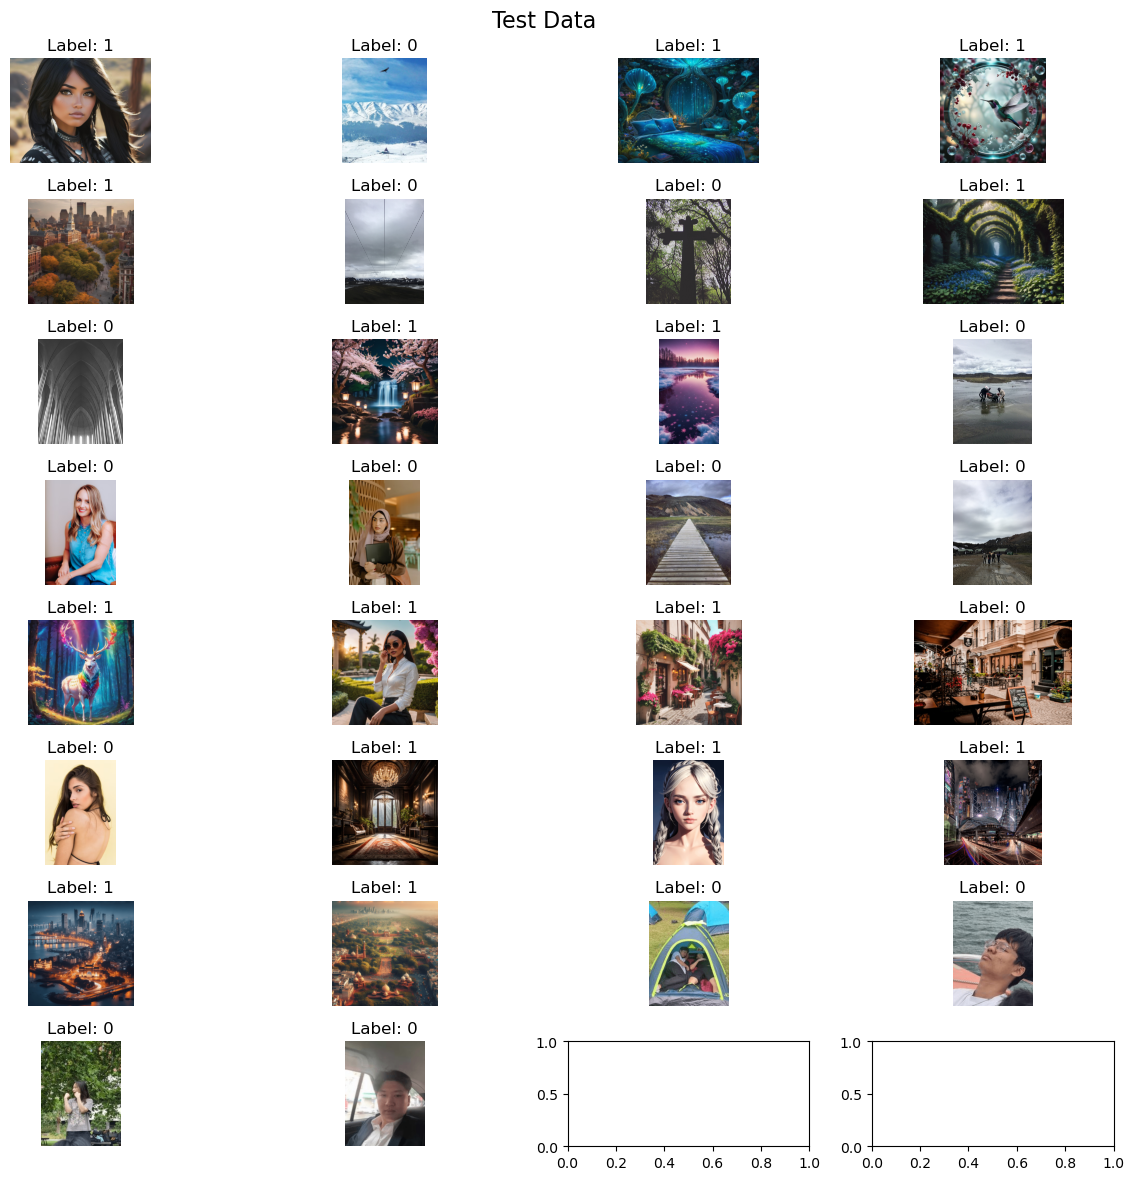

1/1 [==============================] - 2s 2s/step


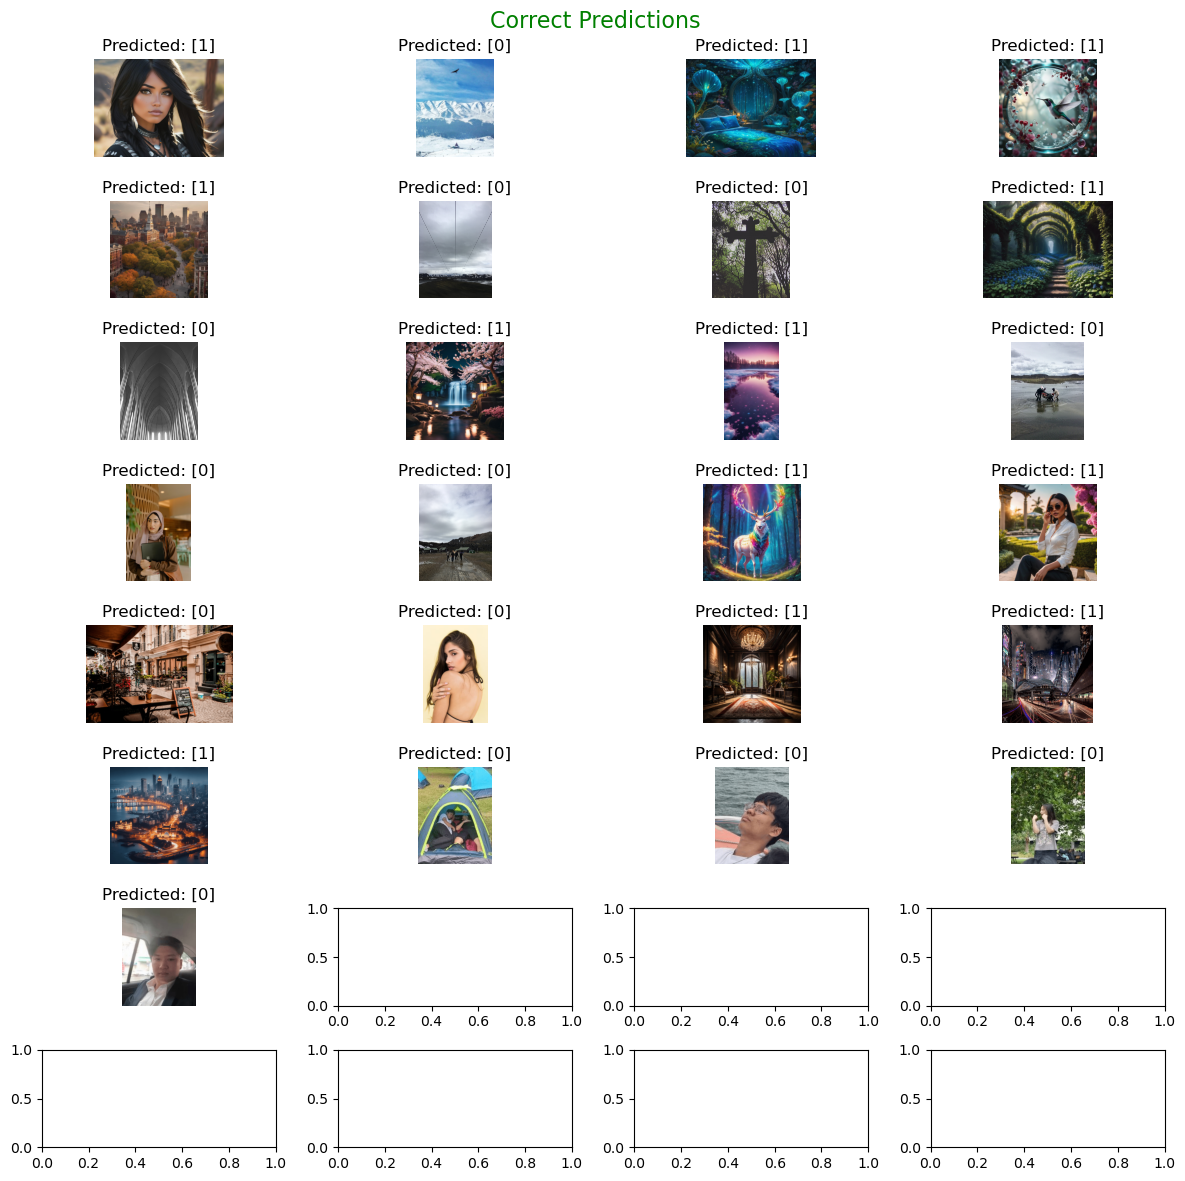

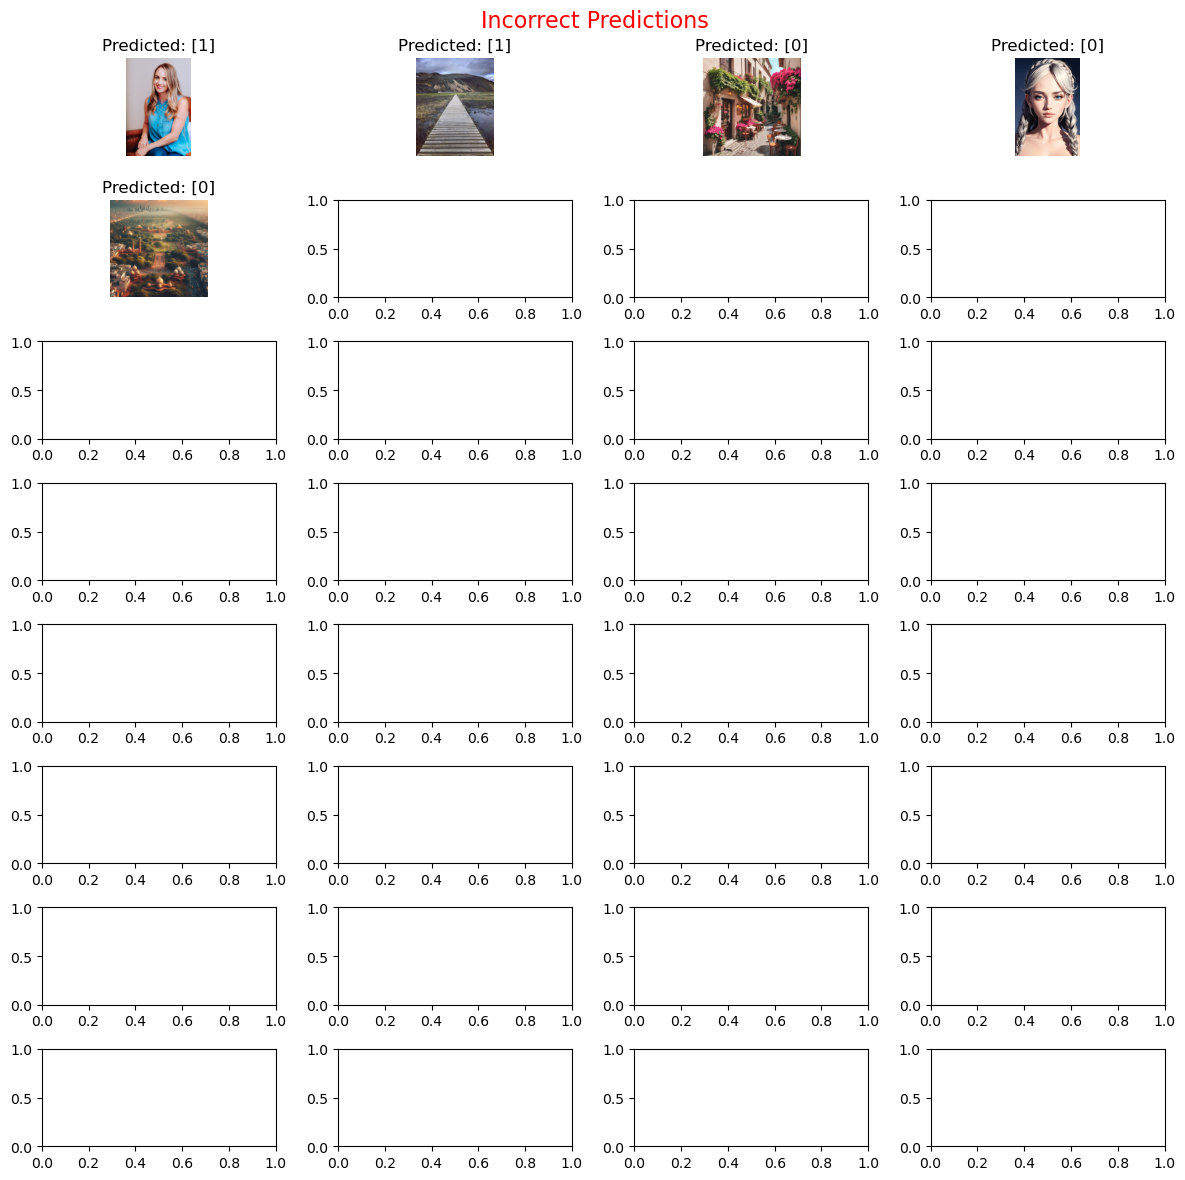

Test Accuracy: 0.8333333333333334


In [37]:
# Load the model architecture
loaded_model = tf.keras.Sequential([
    resnet_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model (necessary before loading weights)
loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Load the weights into the model
loaded_model.load_weights("ai_human_classify_model_weights_resnet152.h5")

# get label of data
labels_file_path = "./data/Data - Is GenAI Test/file_names.csv"
df_data = load_image_labels(labels_file_path)
labels = df_data['Is GenAI'].tolist()
labels = [1 if label == 'Yes' else 0 for label in labels]
labels = np.array(labels)

# get all images
data_path = "./data/Data - Is GenAI Test/"
images_name = df_data['Filename'].tolist()
image_paths = []
# load all the image path that ends with .png into the images_paths list
for filename in images_name:
    image_path = os.path.join(data_path, filename)
    image_paths.append(image_path)

# Load all PNG images in the image_path list and its label
images = [Image.open(image_path) for image_path in image_paths]

predict_images = [preprocess_image_function(image) for image in images]

# Preprocess the images
predict_images = np.array(predict_images)

# plot the images and its labels
num_rows = 8
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for image, label, ax in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    ax.set_title("Label: " + str(label))
    ax.axis('off')
plt.suptitle("Test Data", fontsize=16, color='black')
plt.tight_layout()
plt.show()

# Predict the labels for the images
predictions = loaded_model.predict(predict_images)

# Convert the predictions to binary labels (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)

# Separate the images into correct and incorrect categories based on predictions
correct_images = []
incorrect_images = []

for i, (image, prediction, label) in enumerate(zip(images, binary_predictions, labels)):
    if prediction == label:
        correct_images.append((image, prediction))
    else:
        incorrect_images.append((image, prediction))

# Display correct and incorrect images
num_rows = 8
num_cols = 4

# Display correct images
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
for i, (image, prediction) in enumerate(correct_images[:num_rows*num_cols]):
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(image)
    ax.set_title("Predicted: " + str(prediction))
    ax.axis('off')
plt.suptitle("Correct Predictions", fontsize=16, color='green')
plt.tight_layout()
plt.show()

# Display incorrect images
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
for i, (image, prediction) in enumerate(incorrect_images[:num_rows*num_cols]):
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(image)
    ax.set_title("Predicted: " + str(prediction))
    ax.axis('off')
plt.suptitle("Incorrect Predictions", fontsize=16, color='red')
plt.tight_layout()
plt.show()

# Calculate and print the test accuracy
test_accuracy = len(correct_images) / len(images)
print("Test Accuracy:", test_accuracy)